In [74]:
import os
import torch
import pydicom as pyd
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

print('CUDA available:', torch.cuda.is_available())
torch.version.cuda
print(torch.__version__)


CUDA available: True
2.10.0+cu128


In [75]:
# --- utils for visualization ---
#
#

def resample_to_ref(moving, ref, is_label=True):
    interp = sitk.sitkNearestNeighbor if is_label else sitk.sitkLinear
    return sitk.Resample(
        moving,                  # moving image
        ref,                     # reference image
        sitk.Transform(),        # identity transform
        interp,
        0,                       # default pixel value
        moving.GetPixelID()      # output pixel type
    )

def show_overlay(img_path, seg_path, z=None, alpha=0.35, contour=True):
    img = sitk.ReadImage(img_path)
    seg = sitk.ReadImage(seg_path)

    # Grid control (spacing/size/direction/origin)
    same_grid = (img.GetSize() == seg.GetSize() and
                 img.GetSpacing() == seg.GetSpacing() and
                 img.GetOrigin() == seg.GetOrigin() and
                 img.GetDirection() == seg.GetDirection())
    if not same_grid:
        seg = resample_to_ref(seg, img, is_label=True)

    img_arr = sitk.GetArrayFromImage(img).astype(np.float32)   # (z,y,x)
    seg_arr = sitk.GetArrayFromImage(seg)                      # (z,y,x)

    # Slice
    if z is None:
        # automatic
        counts = (seg_arr > 0).sum(axis=(1,2))
        z = int(np.argmax(counts)) if counts.max() > 0 else img_arr.shape[0]//2

    I = img_arr[z]
    S = seg_arr[z]

    # Normalization
    vmin, vmax = np.percentile(I, (1, 99))
    I_show = np.clip(I, vmin, vmax)

    plt.figure(figsize=(7,7))
    plt.imshow(I_show, cmap="gray")
    plt.title(f"z={z}")

    # 1) Alpha overlay
    mask = (S > 0)
    overlay = np.zeros((*S.shape, 4), dtype=np.float32)
    overlay[mask] = [1.0, 0.0, 0.0, alpha]
    plt.imshow(overlay)

    # 2) Contour
    if contour:
        plt.contour(mask.astype(np.uint8), levels=[0.5], linewidths=1)

    plt.axis("off")
    plt.show()

def show_label_overlay(img_path, seg_path, z=None, alpha=0.45):
    img = sitk.ReadImage(img_path)
    seg = sitk.ReadImage(seg_path)

    if (img.GetSize(), img.GetSpacing(), img.GetOrigin(), img.GetDirection()) != \
       (seg.GetSize(), seg.GetSpacing(), seg.GetOrigin(), seg.GetDirection()):
        seg = resample_to_ref(seg, img, is_label=True)

    img_arr = sitk.GetArrayFromImage(img).astype(np.float32)
    seg_arr = sitk.GetArrayFromImage(seg).astype(np.int32)

    if z is None:
        counts = (seg_arr > 0).sum(axis=(1,2))
        z = int(np.argmax(counts)) if counts.max() > 0 else img_arr.shape[0]//2

    I = img_arr[z]
    L = seg_arr[z]

    vmin, vmax = np.percentile(I, (1, 99))
    I_show = np.clip(I, vmin, vmax)

    plt.figure(figsize=(7,7))
    plt.imshow(I_show, cmap="gray")

    # label color plot
    masked = np.ma.masked_where(L == 0, L)
    plt.imshow(masked, alpha=alpha)

    plt.title(f"z={z}")
    plt.axis("off")
    plt.show()

In [76]:
data_file_path = r"/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000"

In [181]:
def list_dicom_files(root_dir):
    dicoms = []
    for dp, _, fns in os.walk(root_dir):
        for fn in fns:
            p = os.path.join(dp, fn)
            dicoms.append(p)
    return dicoms

dicom_files_name_list =list_dicom_files(data_file_path)
print(dicom_files_name_list)

check_dcm = dicom_files_name_list[0]
print(f"Checking DICOM file: {check_dcm}")
dcm = pyd.dcmread(check_dcm)

slope = float(dcm.RescaleSlope)
intercept = float(dcm.RescaleIntercept)

print(slope, intercept)

raw = dcm.pixel_array.astype(np.int32)

slope = float(dcm.RescaleSlope)
intercept = float(dcm.RescaleIntercept)

hu = raw * slope + intercept

y, x = 200, 200  # rastgele bir nokta seç
print("raw:", raw[y, x], "hu_from_dcm:", hu[y, x])

img = sitk.ReadImage(check_dcm)   # tek dosya da olur
arr = sitk.GetArrayFromImage(img)       # (1, y, x) veya (y, x)

print(arr.shape, arr.max(), arr.min())
print("sitk value:", arr[0,200,200] if arr.ndim==3 else arr[200,200])

['/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36371391', '/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36368168', '/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36369081', '/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36368102', '/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36368234', '/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36369620', '/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36368289', '/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36371402', '/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36370665', '/mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/36368608', '/mnt/research/research/Data/MyocardialScarDefns_

In [175]:
dicom_files = data_file_path
print(f"Data directory: {dicom_files}")
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(dicom_files)
reader.SetFileNames(dicom_names)
image = reader.Execute()
print(f"Image size: {image.GetSize()}")
print(f"Image spacing: {image.GetSpacing()}")
print(f"Image origin: {image.GetOrigin()}")
print(f"Image direction: {image.GetDirection()}")



Data directory: /mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000
Image size: (512, 512, 343)
Image spacing: (0.390625, 0.390625, 0.39999999999999986)
Image origin: (-79.8096875, -313.7366875, 1736.247)
Image direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


In [176]:
# For transform dcm to nifti, we can use sitk.GetArrayFromImage to get the 3D array and then save it as nifti using sitk.WriteImage. However, since we want to crop the image in z dimension, we can directly use sitk.RegionOfInterest to crop the image and then save it as nifti.
#
# 

array = sitk.GetArrayFromImage(image)

size = image.GetSize()  # (x,y,z)

# (x_start, y_start, z_start)
start = [0, 0, 0]

# (x_size, y_size, z_size)
z_size = 460 # we want to keep all slices, so we set z_size to the original size in z dimension like size[2]
new_size = [size[0], size[1], size[2]]

cropped = sitk.RegionOfInterest(image, new_size, start)

sitk.WriteImage(cropped, data_file_path + "/converted_image.nii.gz")

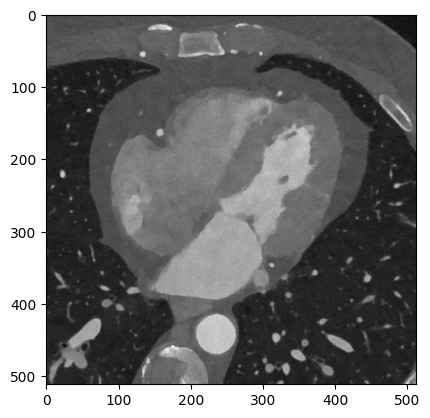

In [178]:
plt.imshow(array[150], cmap='gray')
plt.show()

In [81]:
# Now we have the nifti file, we can use the totalsegmentator to segment the heart chambers. We will use the "heartchambers_highres" task which is specifically designed for high resolution cardiac CT images. The output will be saved in the same directory as the input nifti file.
#
#

from totalsegmentator.python_api import totalsegmentator
if __name__ == "__main__":
    input_file = data_file_path + "/converted_image.nii.gz"
    output_file = data_file_path + "/segmentations"

    out_segmentation = totalsegmentator(
        input=input_file,
        output=output_file,
        fast=False, 
        preview = False,
        task="heartchambers_highres", 
        ml=True, 
        verbose=True
    )

    print(f"Solutions: {output_file}")

Using Device: cuda:0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough segmentation for cropping...
  (Using more robust (but slower) 3mm model for cropping.)
tmp_dir: /tmp/nnunet_tmp_mbk3faof
Resampling...
  from shape (512, 512, 343) to shape (67, 67, 46)
  Resampled in 3.24s
Predicting...
There are 1 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting s01:
perform_everything_on_device: True


100%|██████████| 1/1 [00:00<00:00, 99.97it/s]


sending off prediction to background worker for resampling and export
done with s01
  Predicted in 7.60s
Resampling...
  back to original shape: (512, 512, 343)
Undoing canonical...
Rough organ segmentation generated in 13.66s
tmp_dir: /tmp/nnunet_tmp_su001l6x
  cropping from (512, 512, 343) to (458, 443, 327)
Predicting...
There are 1 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting s01:
perform_everything_on_device: True


100%|██████████| 18/18 [00:00<00:00, 52.77it/s]


sending off prediction to background worker for resampling and export
done with s01
  Predicted in 37.26s
Undoing canonical...
Undoing cropping...
Applying postprocessing: remove outside of crop mask...
  Applied in 1.24s
Saving segmentations...
  Saved in 0.93s
Solutions: /mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/segmentations


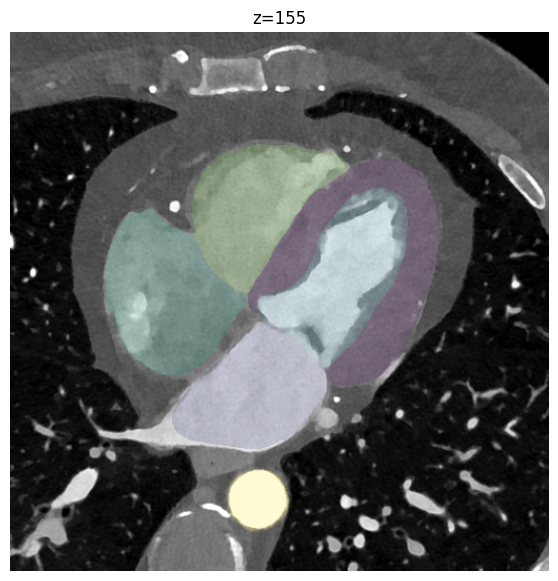

In [85]:
show_label_overlay(input_file, output_file, z=None, alpha=0.2)

In [84]:
from totalsegmentator.map_to_binary import class_map

class_map["heartchambers_highres"]

{1: 'heart_myocardium',
 2: 'heart_atrium_left',
 3: 'heart_ventricle_left',
 4: 'heart_atrium_right',
 5: 'heart_ventricle_right',
 6: 'aorta',
 7: 'pulmonary_artery'}

In [134]:
# Now we have the segmentation result, we can do some post-processing to get the final segmentation mask. We will use binary erosion to remove the small isolated regions and then use k-means clustering to separate the different heart chambers. Finally, we will save the final segmentation mask as a nifti file.
# For 3D version of binary erosion, we can use skimage.morphology.binary_erosion with a 3D structuring element like ball. For k-means clustering, we can use sklearn.cluster.KMeans to cluster the voxels based on their intensity and spatial coordinates. We will also need to normalize the features before clustering. Finally, we will save the final segmentation mask as a nifti file using sitk.WriteImage.
# This is the 3D version

from skimage.morphology import binary_erosion, disk, ball
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

erosion_on = 1
k_means_on = 1
segmentation_mask = 1

seg_sitk = sitk.ReadImage(output_file + ".nii")
ct_sitk = sitk.ReadImage(input_file)
ct_intensities = sitk.GetArrayFromImage(ct_sitk)

voxel_spacing = seg_sitk.GetSpacing()  # (x, y, z)
print("voxel spacing:", voxel_spacing)
origin = seg_sitk.GetOrigin()
direction = seg_sitk.GetDirection()
segmentation = sitk.GetArrayFromImage(seg_sitk)

r_mm = 2.0
r_voxx = max(1, int(round(r_mm / voxel_spacing[0])))
r_voxy = max(1, int(round(r_mm / voxel_spacing[1])))
r_voxz = max(1, int(round(r_mm / voxel_spacing[2])))

print(f"erosion radius in voxels: ({r_voxx}, {r_voxy}, {r_voxz})")

if segmentation_mask:
    segmentation_masked_organ = (segmentation > 0) & (segmentation < 2)  # bool mask
else:
    segmentation_masked_organ = segmentation > 0

if erosion_on:
    mask3d_eroded = binary_erosion(segmentation_masked_organ, footprint=ball(1))
else:
    mask3d_eroded = segmentation_masked_organ

ct_masked = np.where(mask3d_eroded, ct_intensities , 0)

if k_means_on:
    k = 54
    mask = mask3d_eroded.astype(bool)

    # --- features ---
    coords = np.argwhere(mask).astype(np.float32)      # (N,3)
    intens = ct_intensities[mask].reshape(-1, 1).astype(np.float32)  # (N,1)

    # normalize
    coords = (coords - coords.mean(0, keepdims=True)) / (coords.std(0, keepdims=True) + 1e-8)
    #intens = (intens - intens.mean(0, keepdims=True)) / (intens.std(0, keepdims=True) + 1e-8)

    # combine features
    X = np.hstack([intens])

    # --- kmeans ---
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    labels = kmeans.fit_predict(X)     # 0..k-1

    clustered = np.zeros(mask.shape, dtype=np.uint16)
    clustered[mask] = labels + 1       # 1..k

    mask3d_eroded = clustered

else:
    mask3d_eroded = mask3d_eroded

warped_sitk = sitk.GetImageFromArray(mask3d_eroded.astype(np.uint16))
warped_sitk.SetSpacing(voxel_spacing)
warped_sitk.SetOrigin(origin)
warped_sitk.SetDirection(direction)
orienter = sitk.DICOMOrientImageFilter()
orienter.SetDesiredCoordinateOrientation('RAS')
warped_sitk = orienter.Execute(warped_sitk)
sitk.WriteImage(warped_sitk, data_file_path + "/erosioned_img.nii.gz")
print("image saved!")


voxel spacing: (0.390625, 0.390625, 0.4000000059604645)
erosion radius in voxels: (5, 5, 5)


/tmp/ipykernel_2467955/3283921672.py:39: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.erosion` instead. Note the pixel shift by 1 for even-sized footprints (see docstring notes).
  mask3d_eroded = binary_erosion(segmentation_masked_organ, footprint=ball(1))


image saved!


In [198]:
# This is the 2D version
#
#

from skimage.morphology import binary_erosion, disk
import numpy as np
import SimpleITK as sitk
from sklearn.cluster import KMeans

# switches
erosion_on = 1
r_mm = 0.5
repeat_alg = 2
k_means_on = 1
seed_k = 54
segmentation_mask = 1  # True for filtering, else for everything

# read
seg_sitk = sitk.ReadImage(output_file + ".nii")
ct_sitk  = sitk.ReadImage(input_file)

seg = sitk.GetArrayFromImage(seg_sitk)       # (z,y,x)
ct  = sitk.GetArrayFromImage(ct_sitk)        # (z,y,x)

spacing = seg_sitk.GetSpacing()              # (x,y,z)
origin  = seg_sitk.GetOrigin()
direction = seg_sitk.GetDirection()

# --- ROI mask (bool) ---
if segmentation_mask:
    roi = (seg > 0) & (seg < 2)
else:
    roi = (seg > 0)

# --- 2D erosion slice-wise ---
mask_eroded = roi.copy()

if erosion_on:
    r_vox_x = int(round(r_mm / spacing[0]))
    r_vox_y = int(round(r_mm / spacing[1]))
    r_vox = max(1, int(round((r_vox_x + r_vox_y) / 2)))

    print(f"erosion radius in voxels: {r_vox}")
    print(f"erosion radius in mm / repeat: {r_mm} / {repeat_alg}")

    footprint_disk = disk(r_vox)

    mask_eroded = np.zeros_like(roi, dtype=bool)

    for z in range(roi.shape[0]):
        temp_field = roi[z]        
        for _ in range(repeat_alg):
             temp_field = binary_erosion(temp_field, footprint=footprint_disk)

        mask_eroded[z] = temp_field

# --- apply mask to CT for visualize (optional) ---
ct_masked = np.where(mask_eroded, ct, 0)

# --- 2D k-means slice-wise ---
if k_means_on:
    clustered = np.zeros_like(seg, dtype=np.uint16)  # (z,y,x)
    min_vox = 1
    for z in range(mask_eroded.shape[0]):
        m = mask_eroded[z]
        if m.sum() < max(min_vox, seed_k):
            continue

        coords = np.argwhere(m).astype(np.float32)        # (N,2) -> (y,x)
        intens = ct[z][m].reshape(-1, 1).astype(np.float32)

        # normalize
        coords = (coords - coords.mean(0, keepdims=True)) / (coords.std(0, keepdims=True) + 1e-8)
        intens = (intens - intens.mean(0, keepdims=True)) / (intens.std(0, keepdims=True) + 1e-8)

        # feature combine (weightning)
        X = np.hstack([coords])  # (N, 1+2)

        kmeans = KMeans(n_clusters=seed_k, n_init="auto", random_state=0)
        lab = kmeans.fit_predict(X)  # 0..k-1

        clustered[z][m] = (lab + 1).astype(np.uint16)  # 1..k

    out_arr = clustered
else:
    out_arr = mask_eroded.astype(np.uint16)

# --- write output ---
out_sitk = sitk.GetImageFromArray(out_arr)   # array (z,y,x)
out_sitk.SetSpacing(spacing)
out_sitk.SetOrigin(origin)
out_sitk.SetDirection(direction)

orienter = sitk.DICOMOrientImageFilter()
orienter.SetDesiredCoordinateOrientation('RAS')
out_sitk = orienter.Execute(out_sitk)

sitk.WriteImage(out_sitk, data_file_path + "/postproc_2d.nii.gz")
print("saved:", data_file_path + "/postproc_2d.nii.gz")

erosion radius in voxels: 1
erosion radius in mm / repeat: 0.5 / 2


/tmp/ipykernel_2467955/2635572924.py:53: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.erosion` instead. Note the pixel shift by 1 for even-sized footprints (see docstring notes).
  temp_field = binary_erosion(temp_field, footprint=footprint_disk)


saved: /mnt/research/research/Data/MyocardialScarDefns_kycn/p_003/DICOM/25121220/52190000/postproc_2d.nii.gz


intens.shape: (343, 512, 512)
-771
-771
min/max: -1506 9579
p99, p99.9, p99.99: [1629. 1908. 3778.]
count > 3000: 17139  /  89915392
count > 5000: 3785


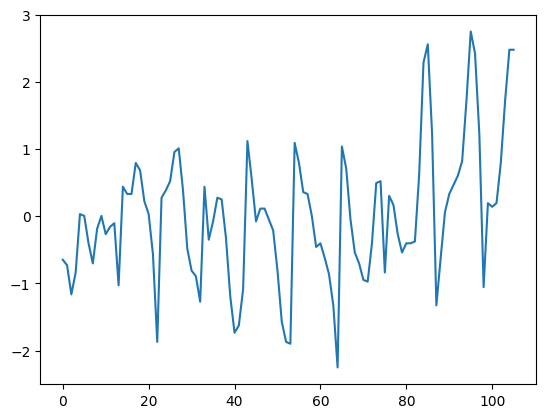

In [201]:
print(f'intens.shape: {ct.shape}')
plt.plot(intens)
plt.show

print(f'{array[200,200,0]}')
print(f'{ct[200,200,0]}')

print("min/max:", ct.min(), ct.max())
print("p99, p99.9, p99.99:", np.percentile(ct, [99, 99.9, 99.99]))
print("count > 3000:", np.sum(ct > 3000), " / ", ct.size)
print("count > 5000:", np.sum(ct > 5000))

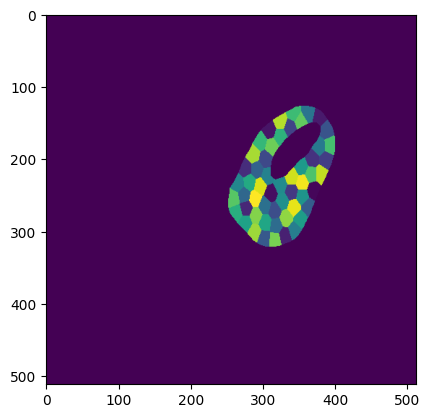

In [199]:
%matplotlib inline

plt.imshow(out_arr[119,:,:])
plt.show()

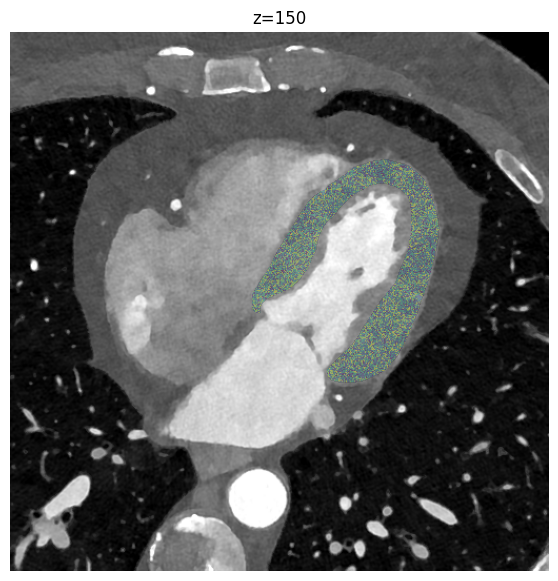

In [191]:
show_label_overlay(input_file, data_file_path + "/postproc_2d.nii.gz", z=150, alpha=0.4)

In [26]:

print(np.unique(mask3d_eroded))

print([f"{i}: {class_map['heartchambers_highres'][i]}" for i in np.unique(mask3d_eroded) if int(i) in class_map["heartchambers_highres"]])

[False  True]
['True: heart_myocardium']
